# **Advanced Topics in Machine Learning: Assignment 3**
# Task 1: Pruning

Pruning, one of the earliest forms of model compression, was first introduced by LeCunn et al. in the seminal ”Optimal
Brain Damage” paper, which laid the foundation for removing redundant parameters from neural networks. Over
time, pruning has evolved into both structured and unstructured variants, each offering different trade-offs in
terms of computational efficiency and performance. In this assignment, we will explore both structured and
unstructured pruning in the context of Convolutional Neural Networks (CNNs), specifically focusing on the
VGG-11 architecture. Our approach will closely follow the methodology of Han et al. (2015) and will draw inspiration from the
first assignment in this neat course.

# 1.1: Unstructured Pruning:

In unstructured pruning, we aim to remove individual weights within the network, focusing on those that contribute
least to the overall performance. For this assignment, you will implement unstructured pruning from scratch, using
an L2-norm magnitude-based approach. By pruning weights with the smallest magnitudes (those closest to zero),
you will iteratively reduce the network’s complexity, setting the target sparsity ratios yourself.
Before and after pruning, it is essential to visualize the distribution of the weights. You’ll notice that pruning primarily affects weights near zero, which is advantageous when the weight distribution follows a bell curve. Visualizing
these changes will help you understand the impact of pruning on the network’s internal structure.
A key part of this section is the sensitivity analysis (see Figure 1). You will independently prune each layer and
observe how varying the target sparsity impacts accuracy. This will allow you to determine whether early or later layers are more sensitive to pruning, and you’ll be expected to reason why this is the case. The final goal is to
adjust the sparsity ratios across layers such that your final pruned model achieves 25% overall sparsity.
To summarize:
1. Use magnitude-based Unstructured Pruning to compress a VGG-11 model, plotting the distribution of the
weight tensors before and after pruning.
2. Perform a sensitivity analysis and visualize which layers are more sensitive to pruning, across a set of sparsity
ratio values.
3. Set the values for the sparsity ratios for each layer yourself, commenting on why you are making the choices
you are. The goal is to have a model that has been pruned with a 25% ratio, on a per-layer basis, and save
this for later.

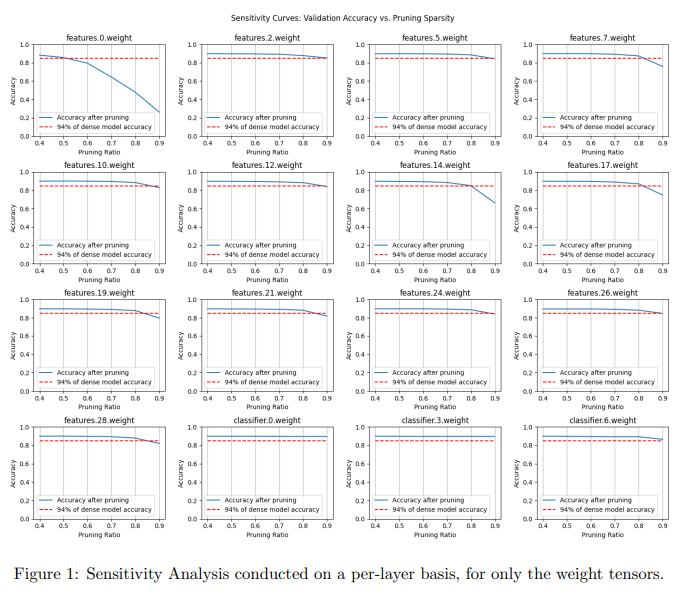


In [ ]:
#Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn.utils.prune as prune
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import autocast, GradScaler
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device= device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Loading CIFAR 10 Dataset

def get_data_loaders_cifar10(batch_size=64):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load CIFAR-10 dataset
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader, 10


train_data,test_data,num_batches=get_data_loaders_cifar10()

print("sanity check")

100%|██████████| 170M/170M [00:18<00:00, 9.25MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
sanity check


In [ ]:
# Load VGG-11 model
model = models.vgg11(pretrained=True)
model.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
model = model.to(device)

print(model)

layer_names = [name for name, module in model.named_modules() if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear))]
print(layer_names)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 221MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
#Training
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=5):

    # Freeze all layers except the last layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier[6].parameters():
        param.requires_grad = True

    model.train()
    scaler = GradScaler()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()


        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (batch_idx + 1) % 20 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {time.time() - start_time:.2f} seconds. "
              f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


In [ ]:
#Implementing Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


train_model(model, train_data, criterion, optimizer, device, num_epochs=5)

torch.save(model.state_dict(), '/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth')


Epoch [1/5], Batch [20/782], Loss: 2.9584
Epoch [1/5], Batch [40/782], Loss: 2.1599
Epoch [1/5], Batch [60/782], Loss: 1.8237
Epoch [1/5], Batch [80/782], Loss: 1.6229
Epoch [1/5], Batch [100/782], Loss: 1.3536
Epoch [1/5], Batch [120/782], Loss: 1.3894
Epoch [1/5], Batch [140/782], Loss: 1.3662
Epoch [1/5], Batch [160/782], Loss: 1.1227
Epoch [1/5], Batch [180/782], Loss: 1.0911
Epoch [1/5], Batch [200/782], Loss: 1.1277
Epoch [1/5], Batch [220/782], Loss: 0.9521
Epoch [1/5], Batch [240/782], Loss: 0.9071
Epoch [1/5], Batch [260/782], Loss: 1.0635
Epoch [1/5], Batch [280/782], Loss: 0.8561
Epoch [1/5], Batch [300/782], Loss: 0.8548
Epoch [1/5], Batch [320/782], Loss: 0.8548
Epoch [1/5], Batch [340/782], Loss: 0.8060
Epoch [1/5], Batch [360/782], Loss: 0.8336
Epoch [1/5], Batch [380/782], Loss: 0.8465
Epoch [1/5], Batch [400/782], Loss: 0.8079
Epoch [1/5], Batch [420/782], Loss: 0.6294
Epoch [1/5], Batch [440/782], Loss: 0.7178
Epoch [1/5], Batch [460/782], Loss: 0.8468
Epoch [1/5], Ba

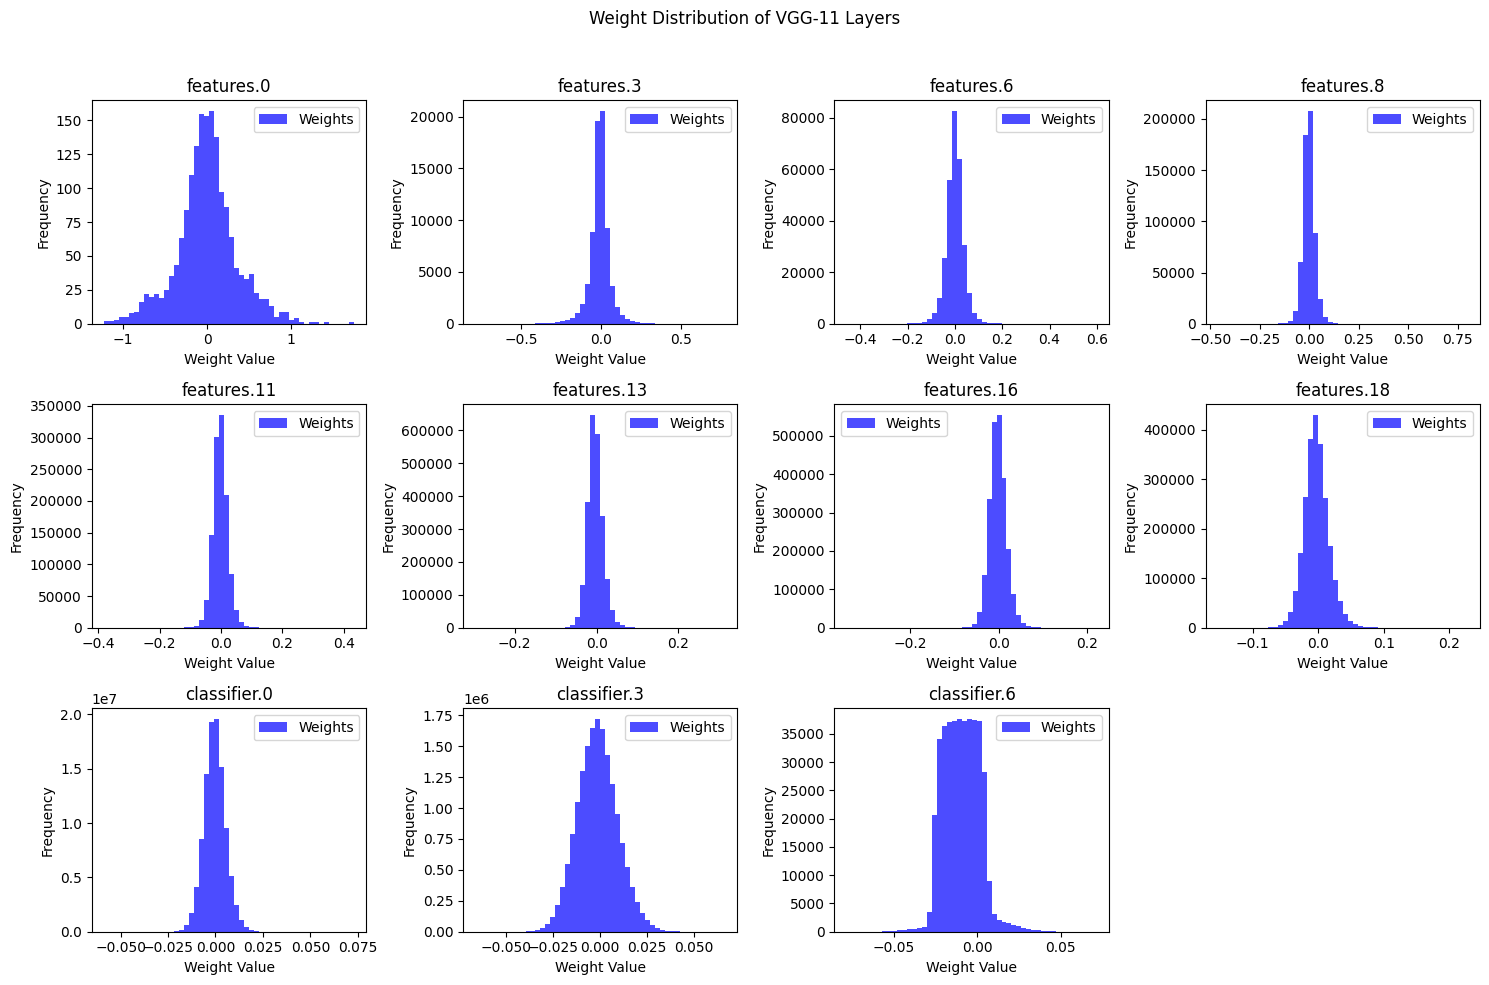

In [ ]:
#Plotting weight distribution of trained VGG Model

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Weight Distribution of VGG-11 Layers")

for i, layer_name in enumerate(layer_names):
    ax = axes[i // 4, i % 4]
    # Access the layer by name
    layer = dict(model.named_modules())[layer_name]
    weights = layer.weight.data.cpu().numpy().flatten()
    ax.set_title(f"{layer_name}")
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Frequency")

    # Plot in the selected subplot
    ax.hist(weights, bins=50, alpha=0.7, color='blue', label='Weights')
    ax.legend()

# Hide any empty subplot if exists
if len(layer_names) < 12:
    for j in range(len(layer_names), 12):
        fig.delaxes(axes.flatten()[j])

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for title
plt.show()

In [ ]:
#Unstructured Pruning function with L2 Norm
def apply_unstructured_pruning_single_layer(layer_name, sparsity):
    model1 = models.vgg11(pretrained=True)
    model1.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
    model1.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
    model1 = model1.to(device)

    for name, module in model1.named_modules():
        if name == layer_name and isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            # Get the weight tensor and calculate the L2 norm of each weight
            weight = module.weight.data
            l2_norms = torch.norm(weight, p=2, dim=0)

            # Flatten and determine the threshold for pruning based on the specified sparsity
            num_weights = l2_norms.numel()
            num_prune = int(num_weights * sparsity)
            if num_prune > 0:
                # Flatten the tensor and calculate the threshold for pruning
                threshold = torch.kthvalue(l2_norms.flatten(), num_prune).values.item()

                # Create a mask based on the threshold and apply it
                mask = (l2_norms >= threshold).float().unsqueeze(0).expand_as(weight)
                module.weight.data = weight * mask  # Apply the mask to the weight tensor

    return model1

In [ ]:
# Evaluation function

# Only need accuracy, commenting out all other metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels=[]
    all_predicted=[]

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    accuracy = correct / total

    return accuracy

print("sanity check")

sanity check


In [ ]:
sparsity_levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
og_acc=evaluate_model(model, test_data, device)
print ("Original Accuracy: ", og_acc)

<ipython-input-10-2c694615bfcc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10

Original Accuracy:  0.8268


<ipython-input-8-9eeea8331e07>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10

[0.8268, 0.3194, 0.1541, 0.1184, 0.1697, 0.1516, 0.1251, 0.1382, 0.1878, 0.1152, 0.0997]
[0.8268, 0.8233, 0.8186, 0.8086, 0.7736, 0.7184, 0.6119, 0.3573, 0.2362, 0.1526, 0.102]
[0.8268, 0.8229, 0.8174, 0.8117, 0.7624, 0.6814, 0.5149, 0.3162, 0.1777, 0.1384, 0.1]
[0.8268, 0.8188, 0.8059, 0.759, 0.6631, 0.6219, 0.562, 0.3703, 0.3031, 0.1874, 0.1002]
[0.8268, 0.8163, 0.789, 0.7146, 0.5792, 0.3632, 0.2581, 0.1998, 0.1892, 0.1956, 0.1006]
[0.8268, 0.8191, 0.8028, 0.778, 0.7313, 0.6691, 0.4875, 0.4182, 0.3331, 0.2646, 0.1]
[0.8268, 0.8119, 0.7814, 0.7373, 0.6928, 0.6201, 0.524, 0.4913, 0.4424, 0.2867, 0.1]
[0.8268, 0.8212, 0.8095, 0.7942, 0.7741, 0.7362, 0.6697, 0.6311, 0.5822, 0.3881, 0.1153]
[0.8268, 0.822, 0.8202, 0.8139, 0.8027, 0.7826, 0.7466, 0.7191, 0.6665, 0.5216, 0.1139]
[0.8268, 0.8167, 0.8076, 0.7975, 0.7955, 0.7769, 0.7564, 0.7275, 0.6634, 0.5016, 0.1]
[0.8268, 0.8258, 0.8237, 0.8201, 0.8079, 0.7777, 0.7417, 0.6939, 0.5821, 0.4858, 0.1]


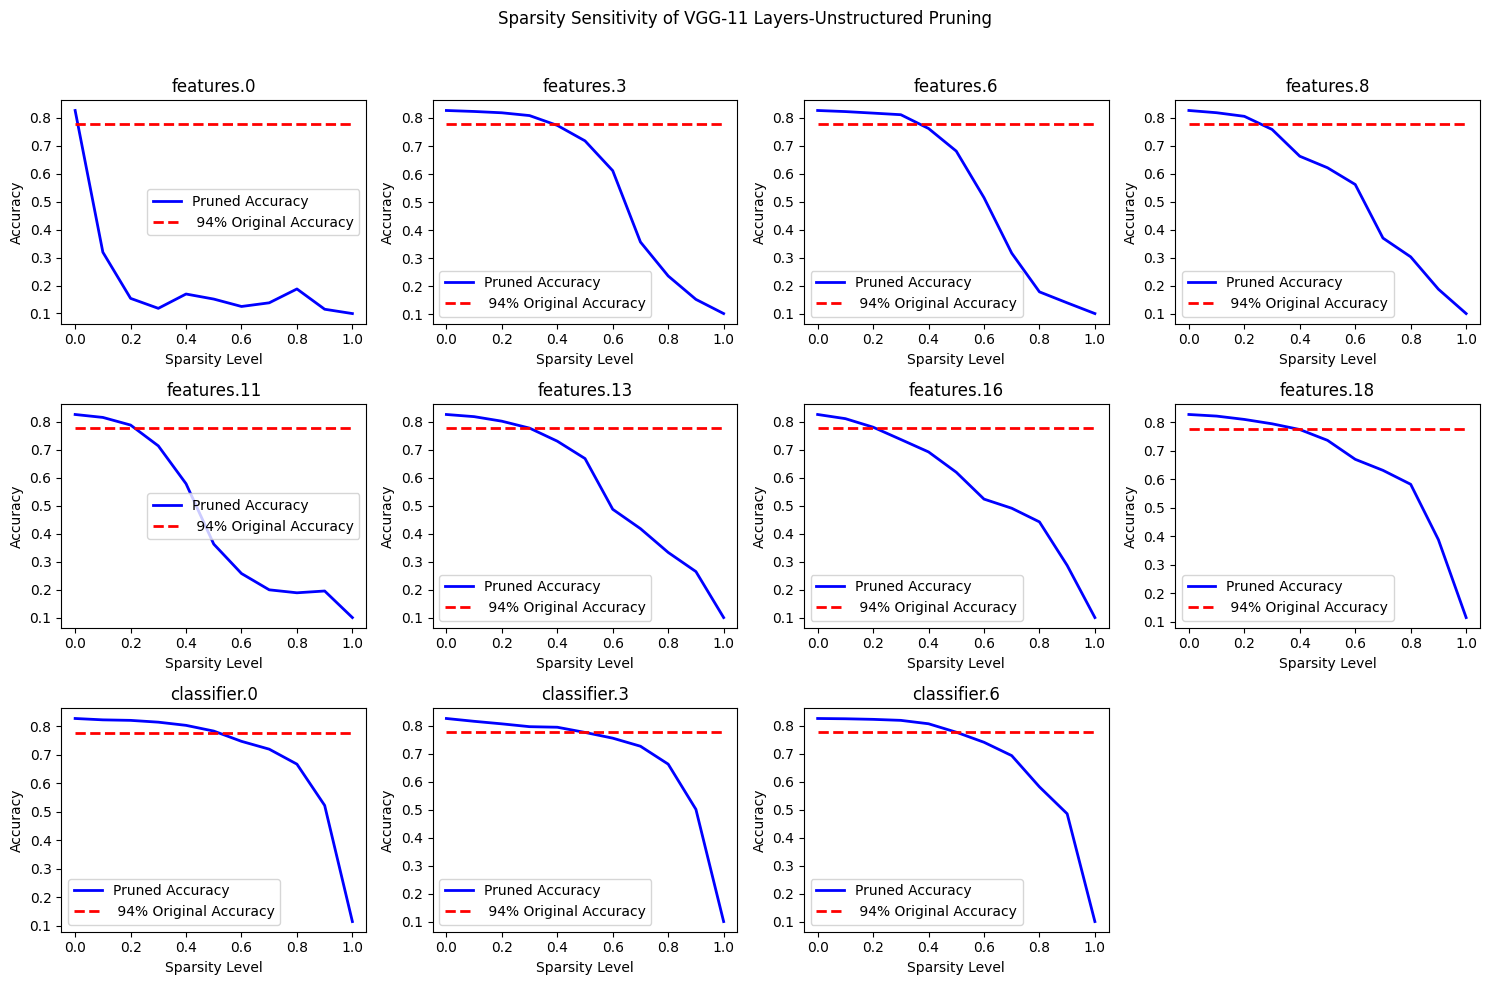

In [ ]:
og_acc_94=0.94*og_acc
og_acc_arr=[]
for j in range(len(sparsity_levels)):
  og_acc_arr.append(og_acc_94)

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Sparsity Sensitivity of VGG-11 Layers-Unstructured Pruning")

for i, layer_name in enumerate(layer_names):
    pruned_acc=[]

    for j in range(len(sparsity_levels)):
        temp_model=apply_unstructured_pruning_single_layer(layer_name, sparsity_levels[j])
        prune_acc=evaluate_model(temp_model,test_data, device)
        # print(prune_acc)
        pruned_acc.append(prune_acc)

    print(pruned_acc)
    ax = axes[i // 4, i % 4]

    ax.set_title(f"{layer_name}")
    ax.set_xlabel("Sparsity Level")
    ax.set_ylabel("Accuracy")

    # Plot in the selected subplot
    ax.plot(sparsity_levels, pruned_acc, color='blue', label='Pruned Accuracy', linewidth=2)
    ax.plot(sparsity_levels, og_acc_arr, color='red', linestyle='--', label=' 94% Original Accuracy', linewidth=2)
    ax.legend()

# Hide any empty subplot if exists
if len(layer_names) < 12:
    for j in range(len(layer_names), 12):
        fig.delaxes(axes.flatten()[j])

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for title
plt.show()



In [ ]:
def calculate_overall_sparsity(model):
    total_weights = 0
    zero_weights = 0

    for name, param in model.named_parameters():
        if 'weight' in name:  # Only consider weight parameters
            total_weights += param.numel()  # Total number of weights
            zero_weights += torch.sum(param == 0).item()  # Count zero weights

    sparsity = zero_weights / total_weights if total_weights > 0 else 0
    return sparsity, zero_weights, total_weights



<ipython-input-13-36aeab376fe0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pt1.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cif

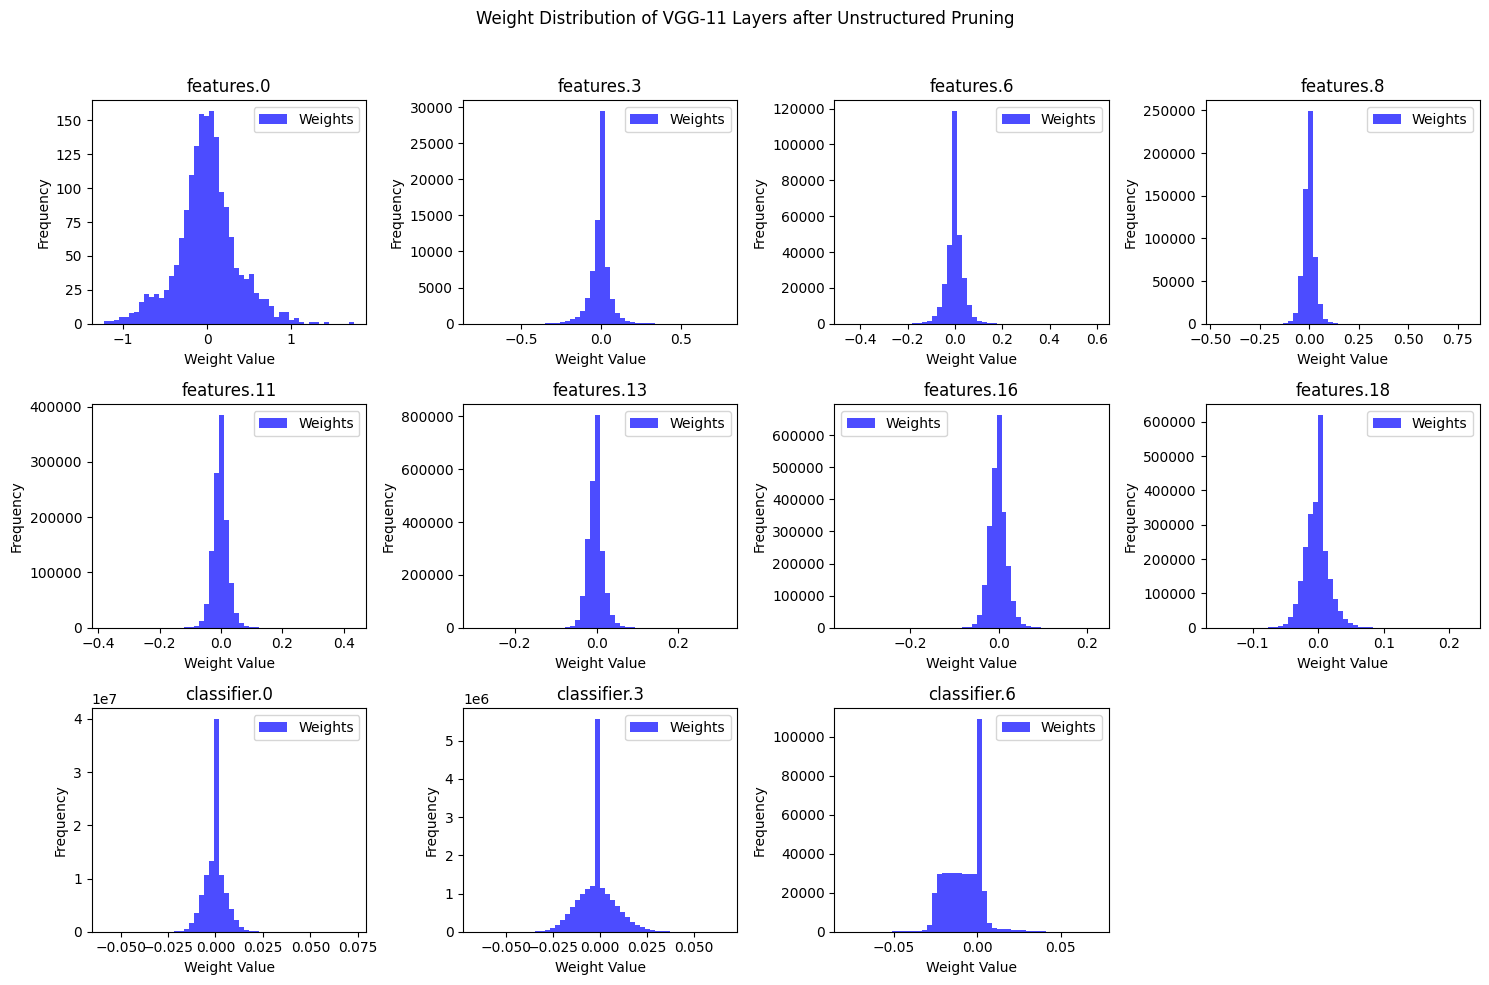

In [ ]:
sparsity_final=[0.0,0.195,0.195,0.13,0.065,0.13,0.065,0.13,0.26,0.26,0.195]

model_pt1 = models.vgg11(pretrained=True)
model_pt1.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
model_pt1.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
model_pt1 = model_pt1.to(device)

for i in range(len(sparsity_final)):
   for name, module in model_pt1.named_modules():
        if name == layer_names[i] and isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            # Get the weight tensor and calculate the L2 norm of each weight
            weight = module.weight.data
            l2_norms = torch.norm(weight, p=2, dim=0)

            # Flatten and determine the threshold for pruning based on the specified sparsity
            num_weights = l2_norms.numel()
            num_prune = int(num_weights * sparsity_final[i])
            if num_prune > 0:
                # Flatten the tensor and calculate the threshold for pruning
                threshold = torch.kthvalue(l2_norms.flatten(), num_prune).values.item()

                # Create a mask based on the threshold and apply it
                mask = (l2_norms >= threshold).float().unsqueeze(0).expand_as(weight)
                module.weight.data = weight * mask  # Apply the mask to the weight tensor

# Calculating Sparsity
sparsity, zero_weights, total_weights = calculate_overall_sparsity(model_pt1)


#Plotting weight distribution of pruned VGG Model
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Weight Distribution of VGG-11 Layers after Unstructured Pruning")

for i, layer_name in enumerate(layer_names):
    ax = axes[i // 4, i % 4]
    # Access the layer by name
    layer = dict(model_pt1.named_modules())[layer_name]
    weights = layer.weight.data.cpu().numpy().flatten()
    ax.set_title(f"{layer_name}")
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Frequency")

    # Plot in the selected subplot
    ax.hist(weights, bins=50, alpha=0.7, color='blue', label='Weights')
    ax.legend()

# Hide any empty subplot if exists
if len(layer_names) < 12:
    for j in range(len(layer_names), 12):
        fig.delaxes(axes.flatten()[j])

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for title
plt.show()

unstructured_sparse_acc=evaluate_model(model_pt1, test_data, device)


torch.save(model_pt1.state_dict(), '/content/drive/MyDrive/Advanced_ML/PA3/vgg_unstructure_prune.pth')

In [ ]:
print ("Original Accuracy: ", og_acc)
print(f"Overall Sparsity: {sparsity:.4f} ({zero_weights} / {total_weights})")
print ("Unstructured Sparse Acc: ", unstructured_sparse_acc)

Original Accuracy:  0.8268
Overall Sparsity: 0.2488 (32132052 / 129164992)
Unstructured Sparse Acc:  0.6955


# 1.2: Structured Pruning:

Structured pruning, on the other hand, removes entire channels or filters rather than individual weights, leading
to more hardware-efficient networks. In this assignment, you will conduct channel-wise pruning, which involves
jointly pruning output channels of one layer and corresponding input channels of the next. This is more complex
than unstructured pruning, as the pruning decisions across layers are interdependent (assuming no special layers
like BatchNorm in between). You are, again, encouraged to follow the structure and guidance from the referenced
course assignment, particularly for implementing magnitude-based pruning across channels.
Similar to unstructured pruning, you will conduct a sensitivity analysis for structured pruning, albeit at a coarser
level. You will investigate whether the sensitivity trends (early vs. later layers) remain consistent with unstructured
pruning. Your final model in this section should also maintain 25% of the original size in terms of memory
footprint.
More precisely:

1. Use magnitude-based Unstructured Pruning to compress a VGG-11 model, plotting the distribution of the
weight tensors before and after pruning.
2. Perform a sensitivity analysis and visualize which layers are more sensitive to pruning, across a set of sparsity
ratio values.
3. Set the values for the sparsity ratios for each layer yourself, commenting on why you are making the choices
you are. The goal is to have a model that has been pruned with a 25% ratio, on a per-layer basis, and save
this for later.

In [ ]:
def apply_structured_pruning_single_layer(layer_name, sparsity):
    model1 = models.vgg11(pretrained=True)
    model1.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
    model1.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
    model1 = model1.to(device)

    for name, module in model1.named_modules():
        if name == layer_name and isinstance(module, (nn.Conv2d, nn.Linear)):
            # Get the weight tensor
            weight = module.weight.data

            # Calculate L2 norm for each filter/channel
            if isinstance(module, nn.Conv2d):
                l2_norms = torch.norm(weight.view(weight.size(0), -1), p=2, dim=1)  # L2 norm for each filter
            elif isinstance(module, nn.Linear):
                l2_norms = torch.norm(weight, p=2, dim=1)  # L2 norm for each neuron

            # Determine the number of filters/neuron to prune
            num_filters = l2_norms.numel()
            num_prune = int(num_filters * sparsity)
            if num_prune > 0:
                # Find the threshold for pruning
                threshold = torch.kthvalue(l2_norms.flatten(), num_prune).values.item()

                # Create a mask for pruning
                mask = (l2_norms >= threshold).float()  # Keep filters/neuron above threshold
                mask = mask.view(-1, 1, 1, 1) if isinstance(module, nn.Conv2d) else mask.view(-1, 1)  # Reshape for Conv2d

                # Apply the mask to the weight tensor
                module.weight.data = weight * mask  # Zero out the pruned filters/neuron

    return model1

In [ ]:
sparsity_levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
og_acc=evaluate_model(model, test_data, device)
print ("Original Accuracy: ", og_acc)

<ipython-input-16-2c694615bfcc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10

Original Accuracy:  0.8268


<ipython-input-15-630034af12f8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar1

[0.8268, 0.8248, 0.8221, 0.8086, 0.7936, 0.7307, 0.5655, 0.4044, 0.2866, 0.1138, 0.1]
[0.8268, 0.8228, 0.8165, 0.7904, 0.7581, 0.6979, 0.6145, 0.3031, 0.2016, 0.1268, 0.1]
[0.8268, 0.8226, 0.8132, 0.7886, 0.7016, 0.6721, 0.4985, 0.3688, 0.2724, 0.153, 0.0989]
[0.8268, 0.8016, 0.6452, 0.5264, 0.3563, 0.2242, 0.1632, 0.1181, 0.1058, 0.1012, 0.1]
[0.8268, 0.8131, 0.7724, 0.7249, 0.6357, 0.5333, 0.4424, 0.3432, 0.2631, 0.1954, 0.1019]
[0.8268, 0.7902, 0.751, 0.6891, 0.6315, 0.5723, 0.3966, 0.2905, 0.2209, 0.1596, 0.1]
[0.8268, 0.8161, 0.7913, 0.7551, 0.747, 0.6226, 0.4301, 0.2342, 0.2036, 0.142, 0.1085]
[0.8268, 0.8224, 0.8085, 0.7967, 0.7761, 0.7442, 0.6548, 0.5704, 0.3791, 0.2666, 0.1041]
[0.8268, 0.8171, 0.8144, 0.8064, 0.7996, 0.7838, 0.7728, 0.7107, 0.6005, 0.4012, 0.1]
[0.8268, 0.8242, 0.8224, 0.8143, 0.8055, 0.7814, 0.7452, 0.6839, 0.5604, 0.2305, 0.1]
[0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.1908]


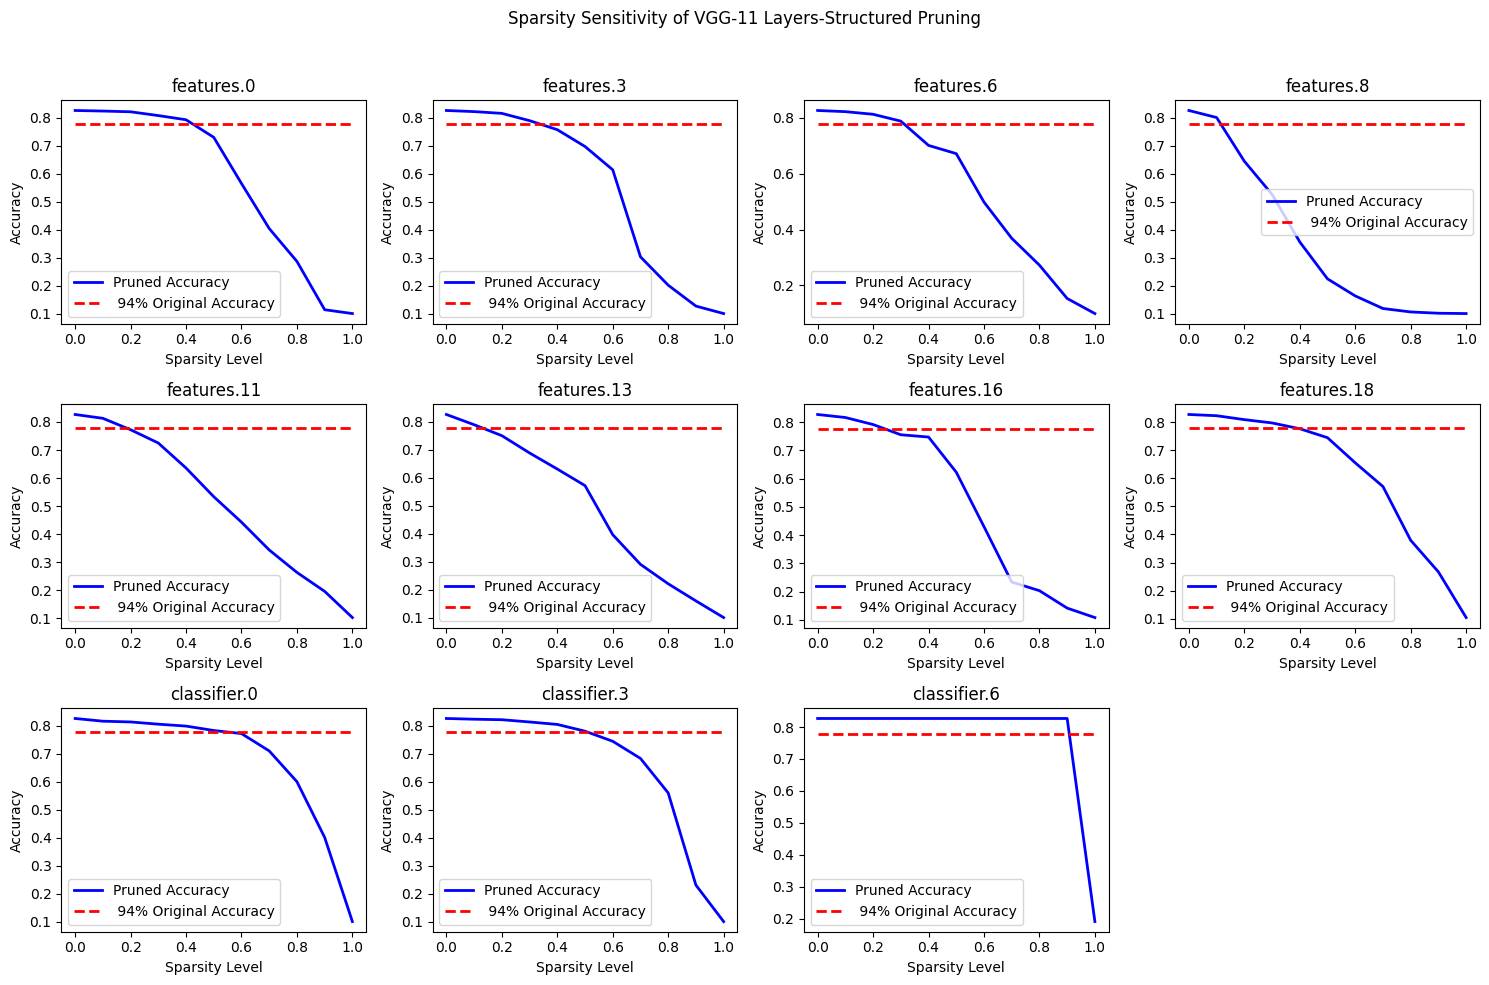

In [ ]:
og_acc_94=0.94*og_acc
og_acc_arr=[]
for j in range(len(sparsity_levels)):
  og_acc_arr.append(og_acc_94)

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Sparsity Sensitivity of VGG-11 Layers-Structured Pruning")

for i, layer_name in enumerate(layer_names):
    pruned_acc=[]

    for j in range(len(sparsity_levels)):
        temp_model=apply_structured_pruning_single_layer(layer_name, sparsity_levels[j])
        prune_acc=evaluate_model(temp_model,test_data, device)
        # print(prune_acc)
        pruned_acc.append(prune_acc)

    print(pruned_acc)
    ax = axes[i // 4, i % 4]

    ax.set_title(f"{layer_name}")
    ax.set_xlabel("Sparsity Level")
    ax.set_ylabel("Accuracy")

    # Plot in the selected subplot
    ax.plot(sparsity_levels, pruned_acc, color='blue', label='Pruned Accuracy', linewidth=2)
    ax.plot(sparsity_levels, og_acc_arr, color='red', linestyle='--', label=' 94% Original Accuracy', linewidth=2)
    ax.legend()

# Hide any empty subplot if exists
if len(layer_names) < 12:
    for j in range(len(layer_names), 12):
        fig.delaxes(axes.flatten()[j])

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for title
plt.show()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-20-837bd2f51c22>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

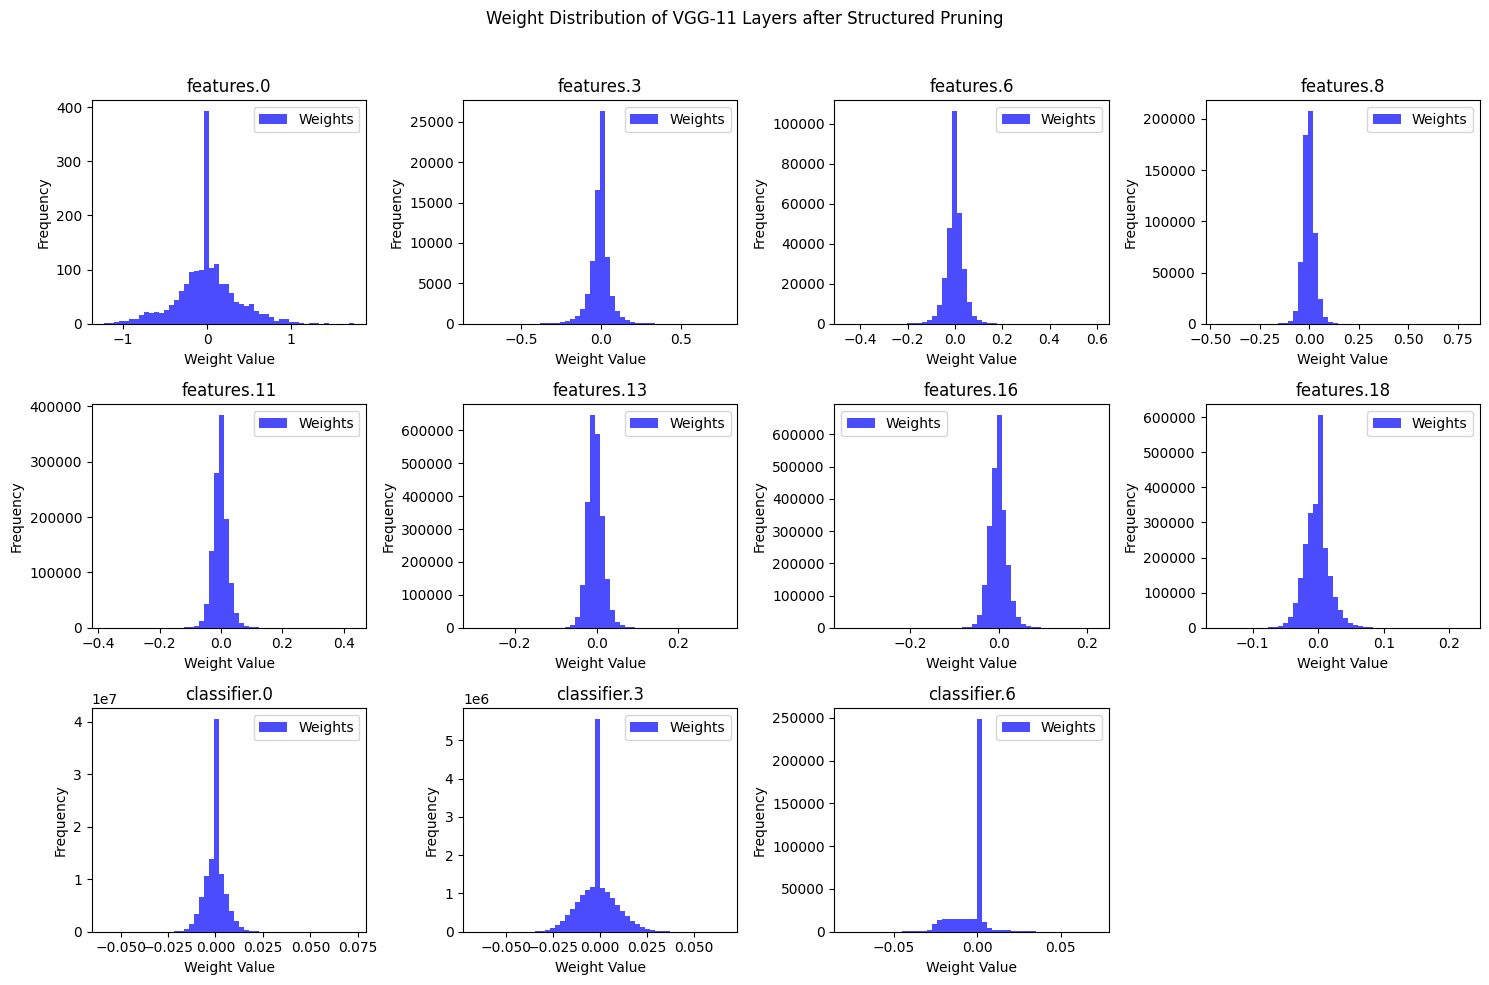

In [ ]:
sparsity_final=[0.195,0.13,0.13,0.0,0.065,0.0,0.065,0.13,0.26,0.26,0.585]

model_pt2 = models.vgg11(pretrained=True)
model_pt2.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
model_pt2.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
model_pt2 = model_pt2.to(device)

for i in range(len(sparsity_final)):
   for name, module in model_pt2.named_modules():
      if name == layer_names[i] and isinstance(module, (nn.Conv2d, nn.Linear)):
          # Get the weight tensor
          weight = module.weight.data

          # Calculate L2 norm for each filter/channel
          if isinstance(module, nn.Conv2d):
              l2_norms = torch.norm(weight.view(weight.size(0), -1), p=2, dim=1)  # L2 norm for each filter
          elif isinstance(module, nn.Linear):
              l2_norms = torch.norm(weight, p=2, dim=1)  # L2 norm for each neuron

          # Determine the number of filters/neuron to prune
          num_filters = l2_norms.numel()
          num_prune = int(num_filters * sparsity_final[i])
          if num_prune > 0:
              # Find the threshold for pruning
              threshold = torch.kthvalue(l2_norms.flatten(), num_prune).values.item()

              # Create a mask for pruning
              mask = (l2_norms >= threshold).float()  # Keep filters/neuron above threshold
              mask = mask.view(-1, 1, 1, 1) if isinstance(module, nn.Conv2d) else mask.view(-1, 1)  # Reshape for Conv2d

              # Apply the mask to the weight tensor
              module.weight.data = weight * mask  # Zero out the pruned filters/neuron

# Calculating Sparsity
sparsity, zero_weights, total_weights = calculate_overall_sparsity(model_pt2)


#Plotting weight distribution of pruned VGG Model
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Weight Distribution of VGG-11 Layers after Structured Pruning")

for i, layer_name in enumerate(layer_names):
    ax = axes[i // 4, i % 4]
    # Access the layer by name
    layer = dict(model_pt2.named_modules())[layer_name]
    weights = layer.weight.data.cpu().numpy().flatten()
    ax.set_title(f"{layer_name}")
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Frequency")

    # Plot in the selected subplot
    ax.hist(weights, bins=50, alpha=0.7, color='blue', label='Weights')
    ax.legend()

# Hide any empty subplot if exists
if len(layer_names) < 12:
    for j in range(len(layer_names), 12):
        fig.delaxes(axes.flatten()[j])

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for title
plt.show()

structured_sparse_acc=evaluate_model(model_pt2, test_data, device)


torch.save(model_pt2.state_dict(), '/content/drive/MyDrive/Advanced_ML/PA3/vgg_structure_prune.pth')

In [ ]:
print ("Original Accuracy: ", og_acc)
print(f"Overall Sparsity: {sparsity:.4f} ({zero_weights} / {total_weights})")
print ("Structured Sparse Acc: ", structured_sparse_acc)

Original Accuracy:  0.8268
Overall Sparsity: 0.2464 (31822569 / 129164992)
Structured Sparse Acc:  0.7328


#1.3: Comparison and Analysis:

After pruning, you will compare the results of the original model, the unstructured pruned model, and the structured
pruned model. You are required to generate Grad-CAM visualizations for each model to analyze how robust
pruning is in terms of accuracy and feature localization (see Figure and refer to this repository https://github.com/jacobgil/pytorch-grad-cam). In your report,
discuss the accuracy drops observed across the different models, as well as the visual differences in the Grad-CAM
outputs.

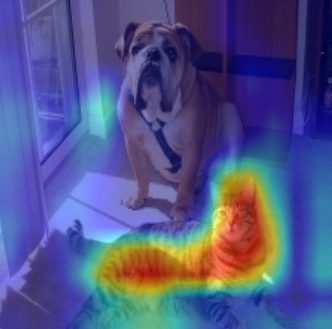

Finally, you will compare structured and unstructured pruning in terms of their ease of application and hardware
requirements. Consider the fact that structured pruning can be more beneficial for certain hardware accelerators
like GPUs, whereas unstructured pruning might run effectively even on CPUs. Additionally, report the inference
times for all three models and graph the accuracy vs. target sparsity (taking 5 readings for this graph).
Put more succinctly,
1. Compare the three models (original, unstructured-pruned, structured-pruned), using a Grad-CAM analysis
to highlight how distinct the models are from each other.
2. Give a qualitative analysis of Structured vs. Unstructured Pruning, highlighting whether there are special
hardware considerations that must be taken into account for either approach or any inherent limitations of
these approaches in general.
3. Compare inference times for a given query image (averaging over a few runs), and compare the storage
on-device (trying to match the sparsity levels as best you can).
4. Using a Pruning approach of your choice, create a single plot of Accuracy vs. Target Sparsity (over the entire
model), showing how the severity of pruning affects performance. You can take up to 5 readings for this.

In [1]:
#Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn.utils.prune as prune
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import autocast, GradScaler
import torchvision.transforms.functional as TF
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device= device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Loading Models
original_model = models.vgg11(pretrained=True)
original_model.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
original_model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
original_model = original_model.to(device)

unstructured_model = models.vgg11(pretrained=True)
unstructured_model.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
unstructured_model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_unstructure_prune.pth'))
unstructured_model = unstructured_model.to(device)

structured_model = models.vgg11(pretrained=True)
structured_model.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
structured_model.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_structure_prune.pth'))
structured_model = structured_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 89.4MB/s]
<ipython-input-3-f4652f37b8f8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to constru

In [4]:
# Loading CIFAR 10 Dataset

def get_data_loaders_cifar10(batch_size=64):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load CIFAR-10 dataset
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return train_loader, test_loader, 10


train_data,test_data,num_batches=get_data_loaders_cifar10()

print("sanity check")

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
sanity check


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
#Defining Grad-CAM class
class GradCAMModel(nn.Module):
    def __init__(self, model):
        super(GradCAMModel, self).__init__()
        self.model = model

        self.features_conv = self.model.features  # Use all convolutional layers
        # self.features_conv = self.model.features[18]  # Use last convolutional layer


        # get the classifier
        # self.classifier = self.model.classifier[6]
        self.classifier = self.model.classifier

        for param in self.model.parameters():
            param.requires_grad = True

        self.gradients = None


    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)
        h = x.register_hook(self.activations_hook)
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)

In [6]:
# Create Grad-CAM models
grad_original = GradCAMModel(original_model)
grad_unstructured = GradCAMModel(unstructured_model)
grad_structured = GradCAMModel(structured_model)

grad_original.to(device).eval()
grad_unstructured.to(device).eval()
grad_structured.to(device).eval()

GradCAMModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_

torch.Size([1, 3, 224, 224])


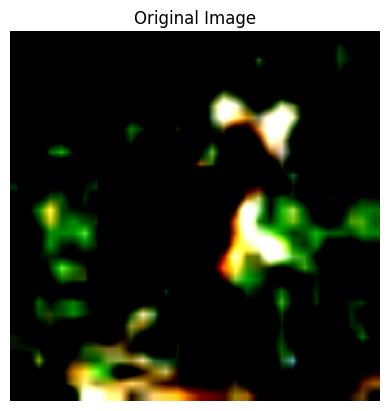

In [7]:
# Get an image for visualization
img, _ = next(iter(test_data))
img = img[2].to(device).unsqueeze(dim=0)
print(img.shape)

# Convert the image from tensor to numpy array for visualization
img_np = img.squeeze().cpu().numpy()  # Remove the batch dimension and move to CPU
img_np = img_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

# Normalize the image for display
# img_np = (img_np * 255).astype(np.uint8)  # Scale to [0, 255]

# Display the original image
plt.title("Original Image")
plt.imshow(img_np)
plt.axis('off')  # Hide the axes
plt.show()

In [8]:
# Forward pass for predictions
pred_original = grad_original(img)
pred_unstructured = grad_unstructured(img)
pred_structured = grad_structured(img)

# print(pred_original[0,:])
# print(pred_unstructured[0,:])
# print(pred_structured[0,:])

# Get predicted classes
class_original = pred_original.argmax(dim=1)
class_unstructured = pred_unstructured.argmax(dim=1)
class_structured = pred_structured.argmax(dim=1)

print(class_original[0])
print(class_unstructured[0])
print(class_structured[0])

# get the gradients of the output with respect to the parameters of the model.
pred_original[0,class_original[0]].backward()
pred_unstructured[0,class_unstructured[0]].backward()
pred_structured[0,class_structured[0]].backward()

# Pull the gradients out of the model
gradients_o = grad_original.get_activations_gradient()
gradients_u = grad_unstructured.get_activations_gradient()
gradients_s = grad_structured.get_activations_gradient()

# Check if gradients are None
if gradients_o is None or gradients_u is None or gradients_s is None:
    print("Gradients are not being captured correctly.")

# Pool the gradients across the channels
pool_o = torch.mean(gradients_o, dim=[0, 2, 3])
pool_u = torch.mean(gradients_u, dim=[0, 2, 3])
pool_s = torch.mean(gradients_s, dim=[0, 2, 3])

# Get the activations of the last convolutional layer
activations_o = grad_original.get_activations(img).detach()
activations_u = grad_unstructured.get_activations(img).detach()
activations_s = grad_structured.get_activations(img).detach()

# Weight the channels by corresponding gradients
for i in range(512):  # Assuming the last conv layer has 512 filters
    activations_o[:, i, :, :] *= pool_o[i]
    activations_u[:, i, :, :] *= pool_u[i]
    activations_s[:, i, :, :] *= pool_s[i]

# averge the channels of the activations
heatmap_o = torch.mean(activations_o, dim=1).squeeze()
heatmap_u = torch.mean(activations_u, dim=1).squeeze()
heatmap_s = torch.mean(activations_s, dim=1).squeeze()

# relu activation
heatmap_o = torch.nn.functional.relu(heatmap_o)
heatmap_u = torch.nn.functional.relu(heatmap_u)
heatmap_s = torch.nn.functional.relu(heatmap_s)

# normalize the heatmap
heatmap_o /=torch.max(heatmap_o)
heatmap_u /=torch.max(heatmap_u)
heatmap_s /=torch.max(heatmap_s)




tensor(4, device='cuda:0')
tensor(6, device='cuda:0')
tensor(4, device='cuda:0')


In [9]:
# Function to create a color map
def apply_colormap(heatmap):
    heatmap = (heatmap * 255).byte()  # Scale to [0, 255]

    # Create a colormap (e.g., using matplotlib)
    colormap = plt.get_cmap('jet')
    heatmap_color = colormap(heatmap.cpu().numpy(), bytes=True)  # Convert to RGBA format
    return torch.tensor(heatmap_color[:, :, :3]).permute(2, 0, 1) / 255 # Keep RGB, normalize to [0, 1]

# Function to overlay heatmaps on an image
def overlay_heatmaps_on_image(img, *heatmaps):
    # Convert the image from tensor to float in [0, 1]
    img_float = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

    # Prepare to blend the heatmaps
    superimposed_img = img_float.clone()

    models = ["original","unstructured","structured"]

    for i, heatmap in enumerate(heatmaps):
        plt.matshow(heatmap.cpu().numpy().squeeze())
        plt.show()
        # Resize heatmap to match image size
        heatmap_resized = torch.nn.functional.interpolate(
            heatmap.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
            size=img.shape[1:],  # Target size (H, W)
            mode='bilinear',
            align_corners=False
        ).squeeze(0).squeeze(0)  # Remove extra dimensions

        # Apply the colormap to the resized heatmap
        heatmap_color = apply_colormap(heatmap_resized)

        # Blend the heatmap with the original image
        superimposed_img = superimposed_img * 0.8 + heatmap_color.permute(1,2,0) * 0.2

        plt.title(f"GradCAM for Model {models[i]}")
        plt.imshow(superimposed_img.numpy())
        plt.axis('off')
        plt.show()


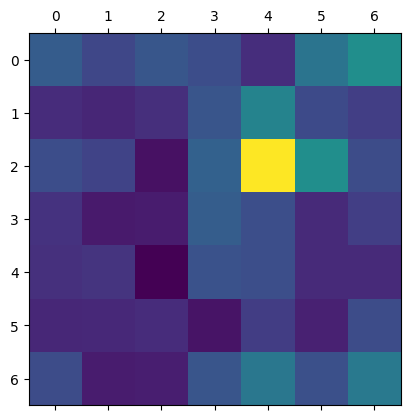

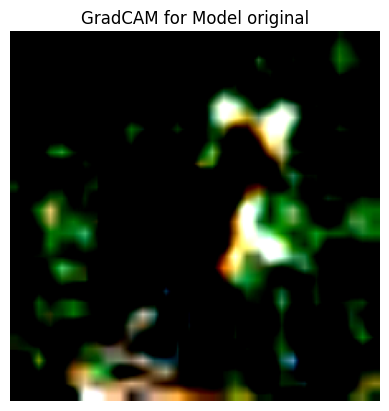

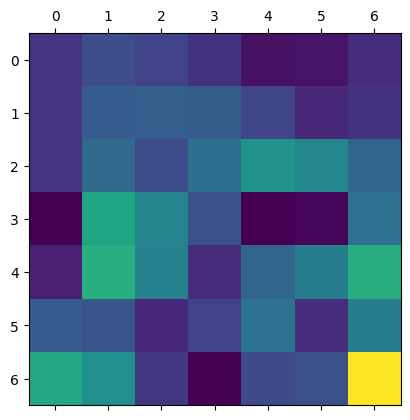

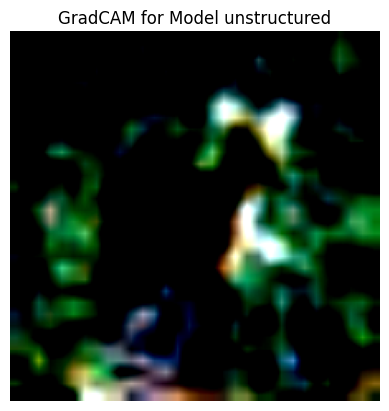

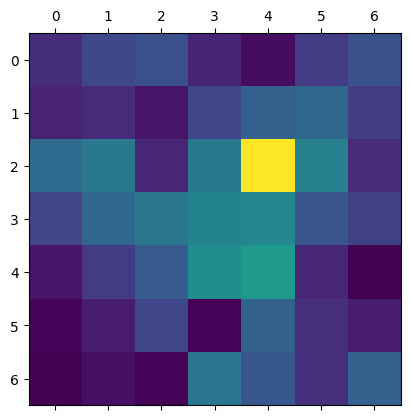

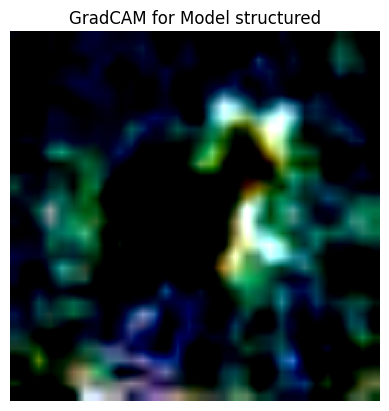

In [10]:
img1 = img.squeeze().cpu()
overlay_heatmaps_on_image(img1, heatmap_o, heatmap_u, heatmap_s)

In [20]:
def measure_inference_time(model, input_tensor, num_runs=2000):
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_runs):
            _ = model(input_tensor)
        end_time = time.time()
    return (end_time - start_time) / num_runs

In [21]:
time_original= measure_inference_time(original_model,img)
time_unstructured=measure_inference_time(unstructured_model,img)
time_structured=measure_inference_time(structured_model,img)

print(f"Average inference time for original model: {1000*time_original:4f} ms")
print(f"Average inference time for unstructured pruned model: {1000*time_unstructured:4f} ms")
print(f"Average inference time for structured pruned model: {1000*time_structured:4f} ms")

Average inference time for original model: 6.132153 ms
Average inference time for unstructured pruned model: 6.220906 ms
Average inference time for structured pruned model: 6.039126 ms


In [13]:
# Evaluation function

# Only need accuracy, commenting out all other metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels=[]
    all_predicted=[]

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    accuracy = correct / total

    return accuracy

print("sanity check")

sanity check


In [14]:
def calculate_overall_sparsity(model):
    total_weights = 0
    zero_weights = 0

    for name, param in model.named_parameters():
        if 'weight' in name:  # Only consider weight parameters
            total_weights += param.numel()  # Total number of weights
            zero_weights += torch.sum(param == 0).item()  # Count zero weights

    sparsity = zero_weights / total_weights if total_weights > 0 else 0
    return sparsity, zero_weights, total_weights

<ipython-input-15-059af9d92dd7>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_j.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifa

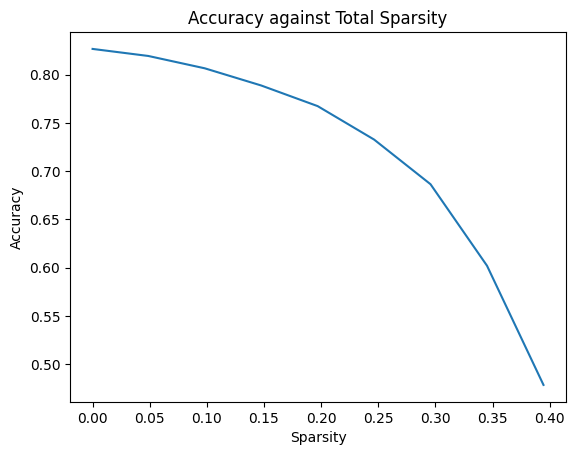

In [15]:
sparsity_val=[0.195,0.13,0.13,0.0,0.065,0.0,0.065,0.13,0.26,0.26,0.585]

sparsities=[]
total_sparsities=[]
accuracies=[]

for j in range(9):
  sparsity_j=[]
  for k in range(len(sparsity_val)):
    sparsity_j.append(0.2*j*sparsity_val[k])
  model_j = models.vgg11(pretrained=True)
  model_j.classifier[6] = nn.Linear(4096, 100)  # Adjusting for CIFAR-100 output
  model_j.load_state_dict(torch.load('/content/drive/MyDrive/Advanced_ML/PA3/vgg_trained_cifar10.pth'))
  model_j = model_j.to(device)
  layer_names = [name for name, module in model_j.named_modules() if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear))]
  for i in range(len(sparsity_val)):
    for name, module in model_j.named_modules():
        if name == layer_names[i] and isinstance(module, (nn.Conv2d, nn.Linear)):
            # Get the weight tensor
            weight = module.weight.data

            # Calculate L2 norm for each filter/channel
            if isinstance(module, nn.Conv2d):
                l2_norms = torch.norm(weight.view(weight.size(0), -1), p=2, dim=1)  # L2 norm for each filter
            elif isinstance(module, nn.Linear):
                l2_norms = torch.norm(weight, p=2, dim=1)  # L2 norm for each neuron

            # Determine the number of filters/neuron to prune
            num_filters = l2_norms.numel()
            num_prune = int(num_filters * sparsity_j[i])
            if num_prune > 0:
                # Find the threshold for pruning
                threshold = torch.kthvalue(l2_norms.flatten(), num_prune).values.item()

                # Create a mask for pruning
                mask = (l2_norms >= threshold).float()  # Keep filters/neuron above threshold
                mask = mask.view(-1, 1, 1, 1) if isinstance(module, nn.Conv2d) else mask.view(-1, 1)  # Reshape for Conv2d

                # Apply the mask to the weight tensor
                module.weight.data = weight * mask  # Zero out the pruned filters/neuron

  total_spars_j,_,_=calculate_overall_sparsity(model_j)
  acc_j=evaluate_model(model_j, test_data, device)
  sparsities.append(sparsity_j)
  total_sparsities.append(total_spars_j)
  accuracies.append(acc_j)



plt.title("Accuracy against Total Sparsity")
plt.plot(total_sparsities,accuracies)
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.show()
